<a href="https://colab.research.google.com/github/Trushali29/Artificial-Intelligence-In-Agritculture/blob/main/LeafClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.Vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [29]:
# unzip the dataset
#!unzip "/content/drive/MyDrive/PlantVillage_Dataset.zip" -d "/content/drive/MyDrive/"

unzip:  cannot find or open /content/drive/MyDrive/PlantVillage_Dataset.zip, /content/drive/MyDrive/PlantVillage_Dataset.zip.zip or /content/drive/MyDrive/PlantVillage_Dataset.zip.ZIP.


In [12]:
#image input size 
IMAGE_SIZE = [224,224]
#providing paths to train and test dataset
train_path ='/content/drive/MyDrive/PlantVillage_Dataset/train' 
valid_path = '/content/drive/MyDrive/PlantVillage_Dataset/validate'

In [13]:
#download inception weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [14]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False 

In [15]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/PlantVillage_Dataset/train/*')

In [16]:
x = Flatten()(inception.output)
x = Dense(500, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [17]:
# summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
# tell the model what cost function and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [19]:
# use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validate_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9600 images belonging to 10 classes.


In [21]:
validate_set = validate_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/validate',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1602 images belonging to 10 classes.


In [22]:
# fit the model
r = model.fit(
  training_set,
  validation_data=validate_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set)
)

Epoch 1/15
300/300 [==============================] - 2960s 10s/step - loss: 1.9815 - accuracy: 0.8219 - val_loss: 0.3775 - val_accuracy: 0.8995
Epoch 2/15
300/300 [==============================] - 1319s 4s/step - loss: 0.2198 - accuracy: 0.9273 - val_loss: 0.2044 - val_accuracy: 0.9401
Epoch 3/15
300/300 [==============================] - 1328s 4s/step - loss: 0.1746 - accuracy: 0.9417 - val_loss: 0.3013 - val_accuracy: 0.9101
Epoch 4/15
300/300 [==============================] - 1331s 4s/step - loss: 0.1613 - accuracy: 0.9470 - val_loss: 0.1798 - val_accuracy: 0.9463
Epoch 5/15
300/300 [==============================] - 1328s 4s/step - loss: 0.1275 - accuracy: 0.9600 - val_loss: 0.1791 - val_accuracy: 0.9513
Epoch 6/15
300/300 [==============================] - 1362s 5s/step - loss: 0.1047 - accuracy: 0.9641 - val_loss: 0.2020 - val_accuracy: 0.9419
Epoch 7/15
300/300 [==============================] - 1376s 5s/step - loss: 0.1131 - accuracy: 0.9619 - val_loss: 0.3551 - val_accuracy

In [23]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_inception.h5') 

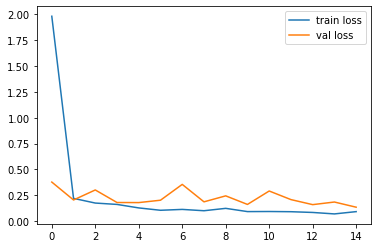

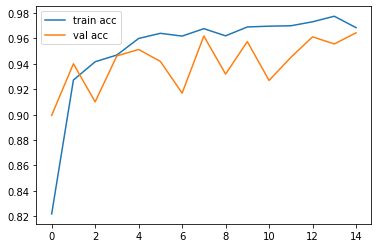

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
from tensorflow.keras.models import load_model
MODEL_PATH = 'model_inception.h5'

#load your trained model
model = load_model(MODEL_PATH)

In [26]:
import matplotlib.image as mpimg
def model_predict(img_path, model):
  print(img_path)
  img = image.load_img(img_path, target_size=(224,224))

  #preprocessing the image 
  x = image.img_to_array(img)

  ## Scaling
  x = x/255
  x = mp.extend_dims(x,axis=0)

  preds = model.predict(x)
  preds = np.argmax(preds, axis=1)
  if preds == 0:
    preds = "The leaf is a Diseased Apple leaf."

  elif preds == 1: 
    preds = "The leaf is a Healthy Apple leaf."

  elif preds == 2:
    preds = "The leaf is a Diseased Cherry leaf."

  elif preds == 3:
    preds = "The leaf is a Healthy Cherry leaf."

  elif preds == 4:
    preds = "The leaf is a Diseased Corn leaf."

  elif preds == 5:
    preds = "The leaf is a Healthy Corn leaf."

  elif preds == 6:
    preds = "The leaf is a Diseased Pepper leaf."

  elif preds == 7:
    preds = "The leaf is a Healthy Pepper leaf."

  elif preds == 8:
    preds = "The leaf is a Diseased Tomato leaf."

  else :
    preds = "The leaf is a Healthy Tomato leaf."

  return preds

In [27]:
def outcome_and_image(img_path,model):
  result = model_predict(img_path,model)
  img = mpimg.imread(img_path)
  print('')
  return plt.imshow(img),result

In [33]:
# diseased apple leaf 
img_path = 'test/Apple_diseased_leaf/dbf66e2f-cf58-418c-9dcd-14254af3ddb1___FREC_Scab 2934.jpg'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

test/Apple_diseased_leaf/dbf66e2f-cf58-418c-9dcd-14254af3ddb1___FREC_Scab 2934.jpg


FileNotFoundError: ignored

In [30]:
# healthy apple leaf 
img_path = 'test/Apple_healthy_leaf/0d776b17-9724-44b9-9186-c89fd17bcf16___RS_HL 8073.jpg'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

test/Apple_healthy_leaf/0d776b17-9724-44b9-9186-c89fd17bcf16___RS_HL 8073.jpg


FileNotFoundError: ignored

In [ ]:
# diseased cherry leaf
img_path='test/Cherry_diseased_leaf/0df55dba-60e0-44e6-b64a-1f4d9a1377fd___FREC_Pwd.M 0527.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

In [ ]:
# healthy cherry leaf
img_path='test/Cherry_healthy_leaf/27ab799c-5868-4386-8891-6b4ae53fa725___JR_HL 9794.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

In [ ]:
# diseased tomato leaf
img_path='test/Tomato_diseased_leaf/0f03a09c-aa48-4d51-95e1-752c466c3742___RS_Erly.B 6413.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

In [ ]:
# healthy tomato leaf
img_path='test/Tomato_healthy_leaf/3b0677fb-ff25-4871-aa89-37f756e917af___GH_HL Leaf 253.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

In [ ]:
# diseased pepper leaf 
img_path = 'test/Pepper_diseased_leaf/e2baac0d-0b5c-4e1d-90d9-70a8d6a6855b___JR_B.Spot 9015.jpg'
im, output = outcome_and_image(img_path, model)
im    
print(f'Result: {output}')

In [ ]:
# healthy pepper leaf 
img_path = 'test/Pepper_diseased_leaf/f6202c30-deb0-498d-8e49-44b012204547___JR_HL 8127.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')